In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme()
pd.options.display.max_rows = 500

In [2]:
fields = ['field_overview',
          'field_status',
          'field_operators',
          'field_owners',
          'field_licensees',
          'field_reserves',
          'field_inplaceVol',
          'field_description',
         ]

In [3]:
from load import load

# Field Licensees

In [4]:
licensees = load(fields[4])

In [5]:
# Current licences don't have a date in 'fldLicenseeTo' field.
curr_lic = licensees[licensees.fldLicenseeTo.isnull()]

## Current Field Licensee Companies

In [6]:
licence_companies = list(enumerate(curr_lic.cmpLongName.unique(), start=1))
print(licence_companies)
select = int(input("Select a company by associate number: "))
company = licence_companies[select-1][1]

[(1, 'Total E&P Norge AS'), (2, 'ConocoPhillips Skandinavia AS'), (3, 'Vår Energi AS'), (4, 'Equinor Energy AS'), (5, 'Petoro AS'), (6, 'DNO Norge AS'), (7, 'INEOS E&P Norge AS'), (8, 'Aker BP ASA'), (9, 'Lundin Energy Norway AS'), (10, 'LOTOS Exploration and Production Norge AS'), (11, 'Mime Petroleum AS'), (12, 'Wintershall Dea Norge AS'), (13, 'Neptune Energy Norge AS'), (14, 'DNO North Sea (UK) Limited'), (15, 'Repsol Sinopec Resources UK Limited'), (16, 'Repsol Norge AS'), (17, 'Dana Petroleum (BVUK) Limited'), (18, 'DNO North Sea (ROGB) Limited'), (19, 'CapeOmega AS'), (20, 'Idemitsu Petroleum Norge AS'), (21, 'OKEA ASA'), (22, 'PGNiG Upstream Norway AS'), (23, 'Sval Energi AS'), (24, 'Edison Norge AS'), (25, 'OMV (Norge) AS'), (26, 'Repsol Sinopec North Sea Limited'), (27, 'Waldorf Production UK Limited'), (28, 'Petrolia NOCO AS'), (29, 'Repsol Sinopec LNS Limited'), (30, 'Suncor Energy Norge AS'), (31, 'NEO Energy Production UK Limited'), (32, 'Wellesley Petroleum AS'), (33, 'A

In [7]:
data = curr_lic.cmpLongName.value_counts()
# Format label strings to only show first word in Company long name
labels = data.index
labelf = [f'{label.split()[0]}' for label in labels]

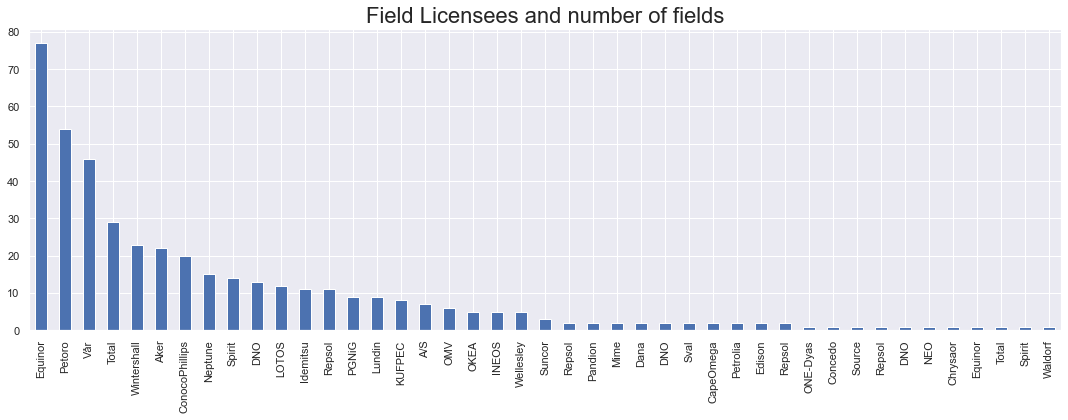

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), tight_layout=True)
data.plot(kind='bar')
ax.xaxis.set_ticklabels(labelf)
plt.xticks(rotation=90); plt.title('Field Licensees and number of fields', fontsize=22)
plt.show()

## Number of Licensees per Field

In [9]:
print(f"Number of Licensees: {licensees['cmpLongName'].nunique()}")
print(f"Number of Fields: {licensees['fldName'].nunique()}")

Number of Licensees: 232
Number of Fields: 124


## Field Licences by selected Company

In [10]:
company.split()[0]

'LOTOS'

In [11]:
company_licences = licensees[licensees['cmpLongName']==company]
company_licences = company_licences.loc[company_licences.groupby('fldName').fldLicenseeFrom.idxmax(),:]

In [12]:
print(f"Number of licences for {company}: {len(company_licences)}")

Number of licences for LOTOS Exploration and Production Norge AS: 12


In [13]:
company_fields = company_licences['fldName']
company_fields

218              ATLA
2223             FRØY
2629           GUNGNE
2877          HEIMDAL
3660      LILLE-FRIGG
5035           SKIRNE
5076    SLEIPNER VEST
5146     SLEIPNER ØST
7323           UTGARD
7330             VALE
8208              YME
8335        ØST FRIGG
Name: fldName, dtype: object

# In place volumes

In [14]:
inplacevols = load(fields[6])

In [15]:
# Function to calculate reserves / volumes
def calculate(fields, df, column='fldName'):
    """
    fields: pd.Series.  Need to convert to list in order to iterate.
    df    : DataFrame from which to calculate either In place volumes or Reserves
    column: Column containing the field names, currently 'fldName' but could change from NPD
    """
    volumes = pd.DataFrame()    
    for field in list(fields):        
        if field in list(df[column]):            
            volumes = volumes.append(df[df[column]==field])
            
    volumes.loc['Total'] = volumes.sum(numeric_only=True, axis=0)
    return volumes

## In place volumes for specified Company

In [16]:
company_inplacevols = calculate(company_fields, inplacevols)

In [17]:
company_inplacevols

,fldName,fldInplaceOil,fldInplaceAssLiquid,fldInplaceAssGas,fldInplaceFreeGas,fldDateOffResEstDisplay,fldNpdidField
3,ATLA,0.0,0.0,0.0,1.88,2019-12-31,21106284.0
26,FRØY,27.0,0.0,6.0,0.00,2019-12-31,43597.0
37,GUNGNE,0.0,15.0,0.0,19.62,2019-12-31,43464.0
41,HEIMDAL,11.0,0.0,0.0,61.40,2019-12-31,43590.0
54,LILLE-FRIGG,4.0,0.0,7.0,0.00,2019-12-31,43583.0
78,SKIRNE,5.0,0.0,0.0,14.72,2019-12-31,2138816.0
81,SLEIPNER VEST,0.0,79.0,0.0,185.11,2019-12-31,43457.0
82,SLEIPNER ØST,0.0,77.0,0.0,90.70,2019-12-31,43478.0
103,UTGARD,0.0,6.0,0.0,4.97,2019-12-31,28975098.0
104,VALE,0.0,10.0,0.0,8.30,2019-12-31,1578893.0


# Reserves

In [18]:
reserves = load(fields[5])

## Reserves for specified Company

In [19]:
company_reserves = calculate(company_fields, reserves)

In [20]:
company_reserves

,fldName,fldRecoverableOil,fldRecoverableGas,fldRecoverableNGL,fldRecoverableCondensate,fldRecoverableOE,fldRemainingOil,fldRemainingGas,fldRemainingNGL,fldRemainingCondensate,fldRemainingOE,fldDateOffResEstDisplay,fldNpdidField
3,ATLA,0.40,1.40,0.00,0.00,1.80,0.00,0.00,0.00,0.0,0.00,2019-12-31,21106284.0
26,FRØY,5.55,1.61,0.00,0.11,7.27,0.00,0.00,0.00,0.0,0.00,2019-12-31,43597.0
37,GUNGNE,0.33,15.77,2.19,4.47,24.73,0.10,0.44,0.05,0.0,0.64,2019-12-31,43464.0
41,HEIMDAL,6.69,46.21,0.00,0.00,52.90,0.00,0.01,0.00,0.0,0.01,2019-12-31,43590.0
54,LILLE-FRIGG,1.33,2.19,0.00,0.02,3.54,0.00,0.00,0.00,0.0,0.00,2019-12-31,43583.0
78,SKIRNE,2.42,10.68,0.00,0.00,13.10,0.07,0.34,0.00,0.0,0.41,2019-12-31,2138816.0
81,SLEIPNER VEST,5.72,146.65,10.58,29.74,202.21,1.58,8.08,0.63,0.0,10.86,2019-12-31,43457.0
82,SLEIPNER ØST,0.37,68.52,13.41,26.62,120.99,0.06,0.27,0.03,0.0,0.39,2019-12-31,43478.0
103,UTGARD,1.06,1.68,0.34,0.00,3.39,0.89,1.54,0.30,0.0,3.00,2019-12-31,28975098.0
104,VALE,2.62,2.64,0.00,0.00,5.26,0.34,0.51,0.00,0.0,0.85,2019-12-31,1578893.0


# Overview

In [21]:
overview = load(fields[0])

<AxesSubplot:xlabel='fldCurrentActivitySatus'>

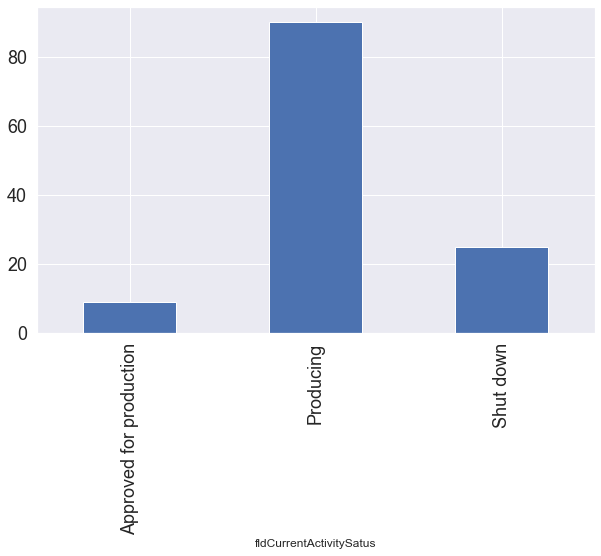

In [22]:
overview.groupby('fldCurrentActivitySatus').size().plot(kind='bar', figsize=(10,6), fontsize=18)

In [23]:
producing_fields = overview[overview['fldCurrentActivitySatus']=='Producing']['cmpLongName'].value_counts()
producing_approved_fields = overview[overview['fldCurrentActivitySatus'].isin(['Approved for production'])]['cmpLongName'].value_counts()
shutdown_fields = overview[overview['fldCurrentActivitySatus']=="Shut down"]['cmpLongName'].value_counts()

print(f"Number of fields: {overview.shape[0]}")
print(f"Number of producing fields: {producing_fields.sum()}")
print(f"Number of producing and approved fields: {producing_approved_fields.sum()}")
print(f"Number of shut down fields: {shutdown_fields.sum()}") # doesn't include 3 NaN entries

Number of fields: 124
Number of producing fields: 90
Number of producing and approved fields: 9
Number of shut down fields: 22


## Status of Fields by Area

fldCurrentActivitySatus  Approved for production  Producing  Shut down
fldMainArea                                                           
Barents Sea                                  1.0        2.0        NaN
North Sea                                    6.0       67.0       24.0
Norwegian Sea                                2.0       21.0        1.0
Column Total                                 9.0       90.0       25.0


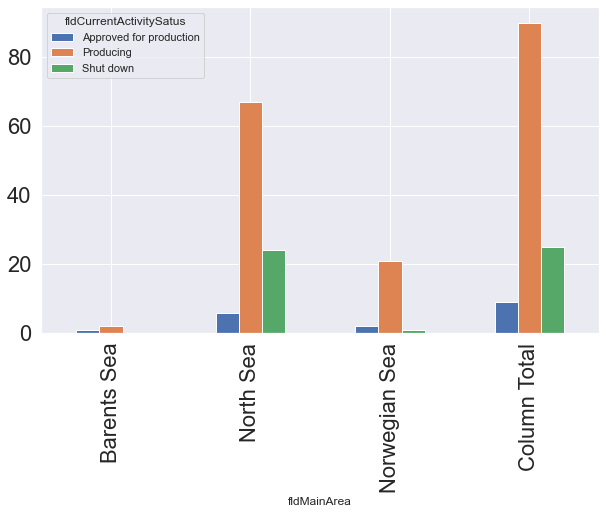

In [24]:
data = overview.groupby(['fldMainArea', 'fldCurrentActivitySatus']).size().unstack()
data.loc['Column Total'] = data.sum(numeric_only=True, axis=0)
print(data)
data.plot(kind='bar', figsize=(10,6), fontsize=22)
plt.show()

# Status

In [25]:
status = load(fields[1])

In [26]:
# status.head()

In [27]:
status.dropna(inplace=True)

status = status.loc[status.groupby('fldName').fldStatusToDate.idxmax(),:]

In [28]:
status['fldStatus'].value_counts()
#  the headings and values look transposed

Approved for production    91
Producing                  24
Shut down                   1
Name: fldStatus, dtype: int64

In [29]:
status['fldName'].nunique()

116

# Operators

In [30]:
operators = load(fields[2])

In [31]:
print(f" Number of Operators: {operators['cmpLongName'].nunique()}")
print(f" Number of Fields: {operators['fldName'].nunique()}")

 Number of Operators: 78
 Number of Fields: 124


In [32]:
# Current Operators don't have a date in the 'fldOperatorTo' field
operators[operators['fldOperatorTo'].isnull()]['cmpLongName'].value_counts() # 121 - doesn't include NaN

Equinor Energy AS                   59
Aker BP ASA                         19
ConocoPhillips Skandinavia AS        9
Vår Energi AS                        5
Wintershall Dea Norge AS             5
Repsol Norge AS                      4
Neptune Energy Norge AS              3
A/S Norske Shell                     3
Lundin Energy Norway AS              3
DNO Norge AS                         2
Spirit Energy Norway AS              2
Total E&P Norge AS                   2
OKEA ASA                             1
Total E&P UK Ltd                     1
Petrogas NEO UK Ltd                  1
Chrysaor Norge AS                    1
Repsol Sinopec North Sea Limited     1
Name: cmpLongName, dtype: int64

# Description

In [33]:
description = load(fields[7])

In [34]:
description.head()

,fldName,fldDescriptionHeading,fldDescriptionText,fldNpdidField,fldDescriptionDateUpdated
0,ALBUSKJELL,Development,Albuskjell is a field in the southern part of ...,43437,2020-02-08
1,ALBUSKJELL,Reservoir,Albuskjell produced gas and condensate from Ma...,43437,2018-03-16
2,ALBUSKJELL,Recovery,The field was produced by pressure depletion.,43437,2017-04-11
3,ALBUSKJELL,Transport,The well stream was transported via pipeline t...,43437,2018-03-16
4,ALBUSKJELL,Status,The field was shut down in 1998 and the platfo...,43437,2020-02-08
